In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Parámetros
img_size = (224, 224)
batch_size = 32

train = r'Datos\Train'
test = r'Datos\Test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2369 images belonging to 3 classes.
Found 592 images belonging to 3 classes.
Found 1050 images belonging to 3 classes.


In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False

# modelo
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
# callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# entrenamiento
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.4005 - loss: 1.2004 - val_accuracy: 0.5878 - val_loss: 0.8962 - learning_rate: 1.0000e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5042 - loss: 0.9662 - val_accuracy: 0.6047 - val_loss: 0.8411 - learning_rate: 1.0000e-04
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5077 - loss: 0.9389 - val_accuracy: 0.6284 - val_loss: 0.8128 - learning_rate: 1.0000e-04
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5252 - loss: 0.9240 - val_accuracy: 0.6503 - val_loss: 0.8023 - learning_rate: 1.0000e-04
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5515 - loss: 0.8801 - val_accuracy: 0.6453 - val_loss: 0.7948 - learning_rate: 1.0000e-04
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5821 - loss: 0.8596 - val_accuracy: 0.6402 - val_loss: 0.7679 - learning_rate: 1.0000e-04
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5571 

33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6243 - loss: 0.9741

Precisión en test: 50.67%
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step

Reporte de Clasificación:
              precision    recall  f1-score   support

 Keratoconus       0.72      0.61      0.66       350
      Normal       0.42      0.90      0.57       350
     Suspect       0.40      0.01      0.01       350

    accuracy                           0.51      1050
   macro avg       0.51      0.51      0.42      1050
weighted avg       0.51      0.51      0.42      1050


Matriz de Confusión:


<Axes: >

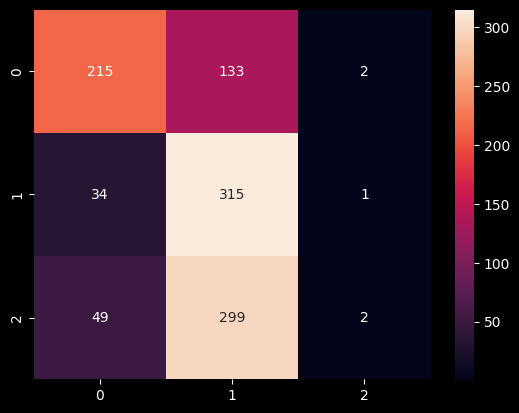

In [ ]:
# test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nPrecisión en test: {test_accuracy * 100:.2f}%")

# reporte
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot = True, fmt = 'g')

In [10]:
# bloques de vgg
base_model.trainable = True
for layer in base_model.layers[:15]:  # 15 capas
    layer.trainable = False

# recompilar con un lr mas bajo
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.5916 - loss: 0.8250 - val_accuracy: 0.6824 - val_loss: 0.6805
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6346 - loss: 0.7778 - val_accuracy: 0.6993 - val_loss: 0.6419
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6325 - loss: 0.7470 - val_accuracy: 0.7128 - val_loss: 0.6182
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.6589 - loss: 0.6966 - val_accuracy: 0.6723 - val_loss: 0.7193
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6328 - loss: 0.7126 - val_accuracy: 0.7449 - val_loss: 0.5911
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6507 - loss: 0.6792 - val_accuracy: 0.7517 - val_loss: 0.5799
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6527 - loss: 0.6711 - val_accuracy: 0.7601 - val_loss: 0.5745
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6678 - loss: 0.6579 - val_accuracy: 0.7821 - v

33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6572 - loss: 0.8113

Precisión en test: 59.43%
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step

Reporte de Clasificación:
              precision    recall  f1-score   support

 Keratoconus       0.87      0.71      0.78       350
      Normal       0.54      0.59      0.57       350
     Suspect       0.44      0.47      0.46       350

    accuracy                           0.59      1050
   macro avg       0.62      0.59      0.60      1050
weighted avg       0.62      0.59      0.60      1050


Matriz de Confusión:


<Axes: >

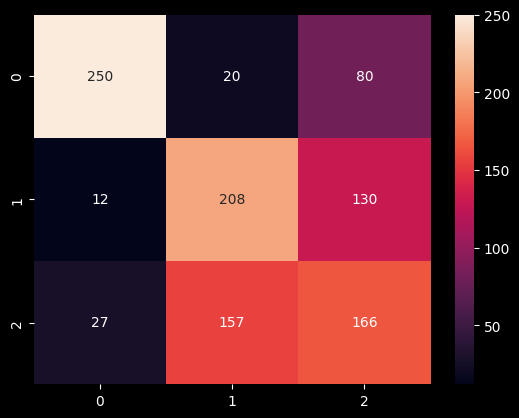

In [12]:
# test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nPrecisión en test: {test_accuracy * 100:.2f}%")

# reporte
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot = True, fmt = 'g')